In [1]:
import time
import numpy as np

from collections import defaultdict
from matplotlib import pyplot as plt
from tqdm import tqdm

from SOL import OptimalLinearBounder
from SOL import functions

from SOL.data_processing import generate_dataset

### A couple of plots

In [17]:
methods_list = ['scipy', 'bisect', 'linear', 'linear_cpp']

Metod scipy, upper bound [0.77688986 0.07441896], lower_bound [ 0.63148288 -0.16295999]


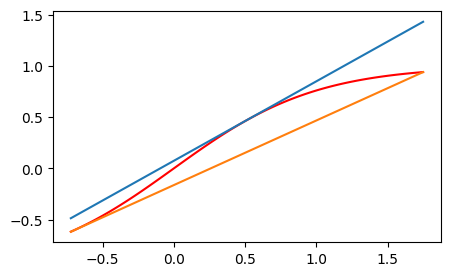

Metod bisect, upper bound [0.77672637 0.07450284], lower_bound [ 0.63168503 -0.16319575]


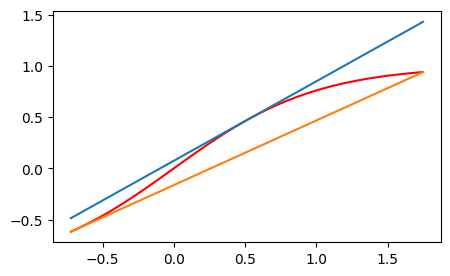

Metod linear, upper bound [0.7763987  0.07467095], lower_bound [ 0.63133643 -0.16306123]


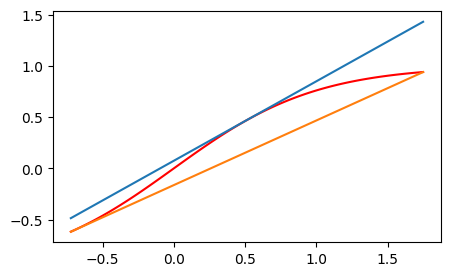

Metod linear_cpp, upper bound [0.77688986 0.07441896], lower_bound [ 0.63148288 -0.16295999]


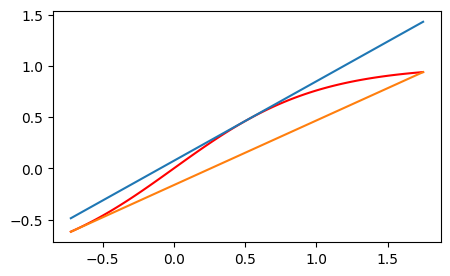

In [26]:
target_function = functions.tanh
target_grad = functions.tanh_grad
datasets = generate_dataset(1, 10 ** 4, [target_function])
boundaries = datasets[0][0]
x = np.linspace(boundaries[0][0], boundaries[0][1], 100)

for method in methods_list:
    bounder = OptimalLinearBounder(
        target_function, target_grad, 5., 5., eps=1e-3, 
        solver=method,
        initial_npoints=10
    )

    lower_bound, upper_bound = bounder.find_optimal_bounds(boundaries)
    print('Metod {}, upper bound {}, lower_bound {}'.format(method, upper_bound, lower_bound))
    
    plt.figure(figsize=(5, 3))
    plt.plot(x, target_function(x), c='red')
    plt.plot(x, x * upper_bound[0] + upper_bound[1])
    plt.plot(x, x * lower_bound[0] + lower_bound[1])
    plt.show()

### A couple of profiles

In [16]:
bench_targets = {
    'gelu': [functions.geluopenai, functions.geluopenai_grad],
    'loglog': [functions.loglog_dr, functions.loglog_grad],
    'swish': [functions.swish, functions.swish_grad],
}

In [17]:
bounds = np.random.rand(1000, 1, 1) * 6 - 3
bounds = np.concatenate((bounds, bounds + 0.1 + np.random.rand(1000, 1, 1) * 3), axis=2)

In [18]:
# eps_values = np.exp(-np.log(10.) * np.linspace(2, 8.5, 15))
eps_values = np.exp(-np.log(10.) * np.linspace(2, 6, 5))
per_eps_results = []

for eps in eps_values:
    print('Eps = {}'.format(eps))

    results = defaultdict(dict)
    for method in methods_list:
        for function_name, func_and_deriv in bench_targets.items():
            times = [time.time()]

            bounder = OptimalLinearBounder(
                func_and_deriv[0], func_and_deriv[1], 5., 5., eps=eps, 
                solver=method,
                initial_npoints=200
            )

            current_results = []
            for bound in tqdm(bounds):
                coeffs_lower, coeffs_upper = bounder.find_optimal_bounds(bound)
                upper_score = coeffs_upper[0] * (bound[0][0] + bound[0][1]) / 2 + coeffs_upper[1]
                lower_score = coeffs_lower[0] * (bound[0][0] + bound[0][1]) / 2 + coeffs_lower[1]
                current_results.append([lower_score, upper_score])
                times.append(time.time())

            results[method][function_name] = (current_results, times)
    
    brief_results = {}
    for method in methods_list:
        method_results = results[method].values()

        total_results = np.array(sum([result[0] for result in method_results], []))
        total_times = np.concatenate(
            [
                np.array(result[1][1:]) - np.array(result[1][:-1])
                for result in method_results
            ]
        )
        
        print('Method {}, performance:'.format(method))
        print(total_results[:, 0].mean())
        print(-total_results[:, 1].mean())
        print(total_times.mean())
        brief_results[method] = (
            total_results[:, 0].mean(),
            -total_results[:, 1].mean(),
            total_times.mean()
        )
        print()

    print('-----' * 5)

    per_eps_results.append(brief_results)

Eps = 0.009999999999999995


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 2474.90it/s]


Method scipy, performance:
0.9260750217209839
-0.9977228258707918
0.0012406628131866454

Method bisect, performance:
0.9274212942268799
-0.997052522793313
0.0001988031069437663

Method linear, performance:
0.9257188492662437
-0.9984170133578282
0.0002962015469868978

Method linear_cpp_1d, performance:
0.9277075230633112
-0.9968672515881416
0.00040470218658447265

-------------------------
Eps = 0.0009999999999999994


100%|██████████| 1000/1000 [00:00<00:00, 1934.06it/s]


Method scipy, performance:
0.9276091695969588
-0.9968055199715853
0.0015203559398651123

Method bisect, performance:
0.9277191401387888
-0.9967306375919417
0.0002758048375447591

Method linear, performance:
0.92752257933077
-0.9968708248312471
0.0006306219895680746

Method linear_cpp_1d, performance:
0.9277262474474984
-0.9967185241662049
0.0005013317267100017

-------------------------
Eps = 9.999999999999991e-05


100%|██████████| 1000/1000 [00:01<00:00, 984.80it/s]


Method scipy, performance:
0.9277838336492813
-0.9966501674584103
0.003085825443267822

Method bisect, performance:
0.9277809883171888
-0.9966518106757771
0.0005931169191996257

Method linear, performance:
0.9277712760422646
-0.996657937970125
0.0017155729134877523

Method linear_cpp_1d, performance:
0.9277878054888893
-0.9966472135033082
0.000994619925816854

-------------------------
Eps = 9.99999999999998e-06


100%|██████████| 1000/1000 [00:01<00:00, 530.50it/s]


Method scipy, performance:
0.9278169156102036
-0.9966227152955652
0.005757039070129395

Method bisect, performance:
0.9278155907522871
-0.9966238662185628
0.0012805988788604735

Method linear, performance:
0.9278155840498222
-0.9966234773082321
0.003570246775945028

Method linear_cpp_1d, performance:
0.9278168839562898
-0.9966228060511569
0.0018907715479532879

-------------------------
Eps = 9.999999999999987e-07


100%|██████████| 1000/1000 [00:02<00:00, 339.28it/s]

Method scipy, performance:
0.9278210041309285
-0.9966192789335878
0.009170068502426148

Method bisect, performance:
0.9278208388098774
-0.9966194166688231
0.002235742171605428

Method linear, performance:
0.9278208912920747
-0.9966193436714036
0.005738198598225911

Method linear_cpp_1d, performance:
0.9278209907205228
-0.9966192933739958
0.0030838961601257326

-------------------------


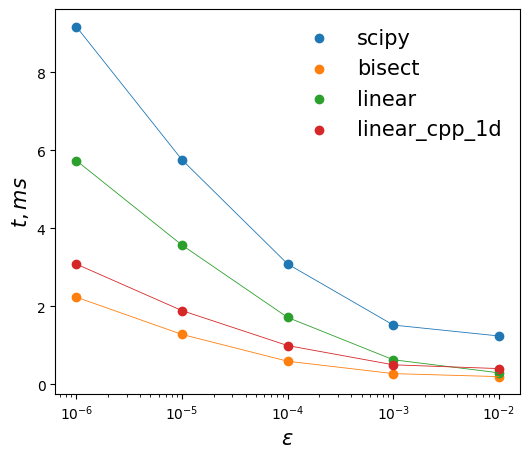

In [19]:
plt.figure(figsize=(6, 5))

for method in methods_list:
    per_eps_performance = [result[method][2] for result in per_eps_results]
    plt.semilogx(eps_values, 1000 * np.array(per_eps_performance), label=None,  linewidth=.6)
    plt.scatter(eps_values, 1000 * np.array(per_eps_performance), label=method)

plt.legend(prop={'size': 15}, frameon=False)
plt.xlabel(r'$\varepsilon$', fontsize=15)
plt.ylabel(r'$t, ms$', fontsize=15)


plt.show()

In [31]:
methods_list = ['scipy', 'linear_cpp']
target_function = functions.loglog_tanh
target_grad = functions.loglog_tanh_grad
bound = np.array([[-0.5, 0.5], [-0.5, 0.5]])

n_test = 100
test_points = np.array([
    [x, y] 
    for x in np.linspace(bound[0][0], bound[0][1], n_test)
    for y in np.linspace(bound[1][0], bound[1][1], n_test)
])
test_values = target_function(*(test_points.T))

for eps in [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]:
    for method in methods_list:
        bounder = OptimalLinearBounder(
            target_function, target_grad, 5., 5., eps=1e-4, 
            solver=method,
            initial_npoints=40
        )

        lower_bound, upper_bound = bounder.find_optimal_bounds(bound)

        upper_discr = (test_values - test_points @ upper_bound[:-1] - upper_bound[-1]).max()
        lower_discr = (test_points @ lower_bound[:-1] + lower_bound[-1] - test_values).max()

        print('Metod {}, upper bound {}, lower_bound {}'.format(method, upper_bound, lower_bound))
        print('Upper bound discrepancy = {}, Lower bound discrepancy = {}'.format(upper_discr, lower_discr))
        
    print('-' * 20)
        
        # plt.figure(figsize=(5, 3))
        # plt.plot(x, target_function(x), c='red')
        # plt.plot(x, x * upper_bound[0] + upper_bound[1])
        # plt.plot(x, x * lower_bound[0] + lower_bound[1])
        # plt.show()

Metod scipy, upper bound [0.14760737 0.4357969  0.08158143], lower_bound [-0.14760737  0.4357969  -0.08158143]
Upper bound discrepancy = -2.3259612908846372e-05, Lower bound discrepancy = -2.3259612908832494e-05
Metod linear_cpp, upper bound [-0.05207092  0.63547519  0.08159571], lower_bound [-0.14649392  0.43691035 -0.08159644]
Upper bound discrepancy = -4.3799748027137375e-05, Lower bound discrepancy = -4.453314331759328e-05
--------------------
Metod scipy, upper bound [0.14760737 0.4357969  0.08158143], lower_bound [-0.14760737  0.4357969  -0.08158143]
Upper bound discrepancy = -2.3259612908846372e-05, Lower bound discrepancy = -2.3259612908832494e-05
Metod linear_cpp, upper bound [-0.05207092  0.63547519  0.08157529], lower_bound [-0.14649392  0.43691035 -0.08159644]
Upper bound discrepancy = -2.3387762550661217e-05, Lower bound discrepancy = -4.4533143317204704e-05
--------------------
Metod scipy, upper bound [0.14760737 0.4357969  0.08158143], lower_bound [-0.14760737  0.435796